In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import moviepy.editor
import os

In [255]:
data_id = '00'

# measurements in meters
PEN_LENGTH = 0.1
PEN_RADIUS = 0.0117

In [256]:
def read_mocap_csv(fname):
    with open(fname) as f:
        # Ignore first 6 lines (header) and only take first 20 columns
        df = pd.read_csv(f, skiprows=6, usecols=range(20))

        # Rename columns
        df.columns = [
            'frame',
            'time',
            'canvas_1_x',
            'canvas_1_y',
            'canvas_1_z',
            'canvas_2_x',
            'canvas_2_y',
            'canvas_2_z',
            'canvas_3_x',
            'canvas_3_y',
            'canvas_3_z',
            'pen_1_x',
            'pen_1_y',
            'pen_1_z',
            'pen_2_x',
            'pen_2_y',
            'pen_2_z',
            'pen_3_x',
            'pen_3_y',
            'pen_3_z',
        ]
        return df

df = read_mocap_csv(f"mocap_dataset/{data_id}/mocap.csv")
df.head()

,frame,time,canvas_1_x,canvas_1_y,canvas_1_z,canvas_2_x,canvas_2_y,canvas_2_z,canvas_3_x,canvas_3_y,canvas_3_z,pen_1_x,pen_1_y,pen_1_z,pen_2_x,pen_2_y,pen_2_z,pen_3_x,pen_3_y,pen_3_z
0,0,0.000,185.582565,6.751027,-599.492798,183.939331,7.620382,-358.981781,-3.846201,9.934978,-602.148682,132.665756,115.011086,-277.280701,135.202316,122.576935,-253.862823,114.016190,127.280327,-266.261414
1,1,0.005,185.582703,6.746553,-599.499756,183.945099,7.627269,-358.984344,-3.867870,10.028675,-602.221863,132.601410,114.994209,-277.330658,135.358551,122.771873,-253.746063,114.004829,127.260628,-266.263885
2,2,0.010,185.573395,6.734292,-599.503845,183.958542,7.645902,-358.981384,-3.872364,9.903111,-602.152161,132.644638,115.014168,-277.302307,135.395966,122.807091,-253.750031,113.999306,127.246826,-266.264374
3,3,0.015,185.573227,6.737552,-599.503235,183.930008,7.636312,-358.979126,-3.867037,9.894382,-602.149353,132.622406,114.983116,-277.340393,135.401932,122.800987,-253.763290,114.005219,127.266228,-266.252380
4,4,0.020,185.584335,6.720970,-599.493774,183.949051,7.638182,-358.979095,-3.822138,10.046946,-602.206787,132.643478,115.014793,-277.283295,135.407104,122.809448,-253.751663,114.014908,127.275620,-266.272644


In [257]:
idxs = []
states = []
for i in range(len(df)):
    canvas_1 = np.array([df['canvas_1_x'][i], df['canvas_1_y'][i], df['canvas_1_z'][i]])
    canvas_2 = np.array([df['canvas_2_x'][i], df['canvas_2_y'][i], df['canvas_2_z'][i]])
    canvas_3 = np.array([df['canvas_3_x'][i], df['canvas_3_y'][i], df['canvas_3_z'][i]])
    pen_1 = np.array([df['pen_1_x'][i], df['pen_1_y'][i], df['pen_1_z'][i]])
    pen_2 = np.array([df['pen_2_x'][i], df['pen_2_y'][i], df['pen_2_z'][i]])
    pen_3 = np.array([df['pen_3_x'][i], df['pen_3_y'][i], df['pen_3_z'][i]])

    state = np.array([canvas_1, canvas_2, canvas_3, pen_1, pen_2, pen_3])
    if np.isnan(state).any():
        continue
    idxs.append(i)
    states.append(state)
states = np.array(states)

In [258]:
# Calculate centroid of each pen position (average of the 3 pen markers)
pen_centroids_x = np.mean(states[:,3:,0], axis=1)
pen_centroids_y = np.mean(states[:,3:,1], axis=1)
pen_centroids_z = np.mean(states[:,3:,2], axis=1)
pen_centroids = np.stack([pen_centroids_x, pen_centroids_y, pen_centroids_z], axis=1) # (N, 3)

# Estimate pen radius
distances = np.linalg.norm(states[:,3:,:] - np.expand_dims(pen_centroids, axis=1), axis=2)
pen_radius = np.median(distances)

# Scale states to be in meters
states = states / pen_radius * PEN_RADIUS
pen_centroids = pen_centroids / pen_radius * PEN_RADIUS

In [259]:
# Calculate direction of pen by taking the cross product
us = states[:,3,:] - pen_centroids
vs = states[:,4,:] - pen_centroids
direction = np.cross(us, vs) # (N, 3)
direction = direction / np.linalg.norm(direction, axis=1)[:,np.newaxis]

# Calculate pen tip positions
pen_tips = []
for i in range(states.shape[0]):
    centroid = pen_centroids[i]

    # Out of these 2, pick the candidate that is closer to the canvas plane
    tip1 = centroid + direction[i] * PEN_LENGTH
    tip2 = centroid - direction[i] * PEN_LENGTH

    canvas_p1 = states[i,0]
    canvas_p2 = states[i,1]
    canvas_p3 = states[i,2]
    canvas_normal = np.cross(canvas_p2 - canvas_p1, canvas_p3 - canvas_p1)
    canvas_normal = canvas_normal / np.linalg.norm(canvas_normal)

    # Calculate length of projection of each tip onto the canvas plane
    tip1_dist = abs(np.dot(tip1 - canvas_p1, canvas_normal))
    tip2_dist = abs(np.dot(tip2 - canvas_p1, canvas_normal))

    if tip1_dist < tip2_dist:
        pen_tips.append(tip1)
    else:
        pen_tips.append(tip2)
pen_tips = np.array(pen_tips)


In [260]:
# Calculate fourth canvas corner
# Find corner that makes 90 deg with the other two, then use that to find the fourth
middle_corner = None
side_corners = None
fourth_corner = None
best_diff = np.inf
for i in range(3):
    cur_corner = states[0,i] # (3,)
    other_corners = []
    for j in range(3):
        if i != j:
            other_corners.append(states[0,j])
    vec1 = other_corners[0] - cur_corner
    vec2 = other_corners[1] - cur_corner
    angle = np.arccos(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))
    diff = np.abs(angle - np.pi/2)
    if diff < best_diff:
        best_diff = diff
        middle_corner = cur_corner
        side_corners = other_corners
        fourth_corner = cur_corner + vec1 + vec2

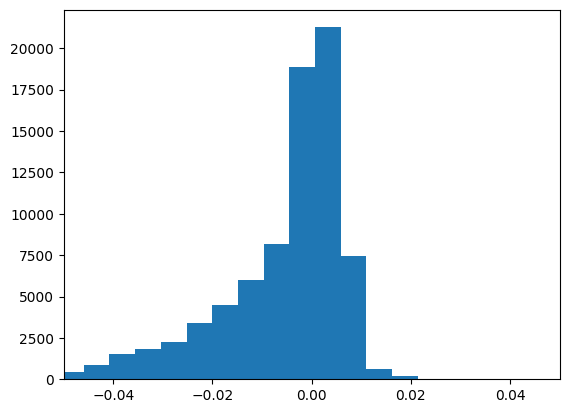

In [265]:
# Plot heights of pen tip above canvas plane as histogram
canvas_p1 = states[0,0]
canvas_p2 = states[0,1]
canvas_p3 = states[0,2]
canvas_normal = np.cross(canvas_p2 - canvas_p1, canvas_p3 - canvas_p1)
canvas_normal = canvas_normal / np.linalg.norm(canvas_normal)

heights = np.dot(pen_tips - canvas_p1, canvas_normal)

plt.hist(heights, bins=100)
plt.xlim([-0.05, 0.05])
plt.show()

CANVAS_MIN_HEIGHT = -0.01
CANVAS_MAX_HEIGHT = 0.01

In [266]:
# For each pen tip position, project it onto the canvas plane.
# If the height above the canvas plane is within the range [CANVAS_MIN_HEIGHT, CANVAS_MAX_HEIGHT],
# then the pen tip is considered to be on the canvas. Calculate the canvas coordinates of the pen tip.

touch_positions_global = []
touch_positions_canvas = []
for pos in pen_tips:
    height = np.dot(pos - canvas_p1, canvas_normal)
    if CANVAS_MIN_HEIGHT <= height <= CANVAS_MAX_HEIGHT:
        u1 = side_corners[0] - middle_corner
        u2 = side_corners[1] - middle_corner

        # Calculate pen tip position in basis u1, u2
        x = np.dot(pos - middle_corner, u1) / np.linalg.norm(u1) ** 2
        y = np.dot(pos - middle_corner, u2) / np.linalg.norm(u2) ** 2
        touch_positions_canvas.append([x, y])
        touch_positions_global.append(middle_corner + x*u1 + y*u2)
    else:
        touch_positions_canvas.append([None, None])
        touch_positions_global.append([None, None, None])
touch_positions_canvas = np.array(touch_positions_canvas)
touch_positions_global = np.array(touch_positions_global)

(0.0, 1.0)

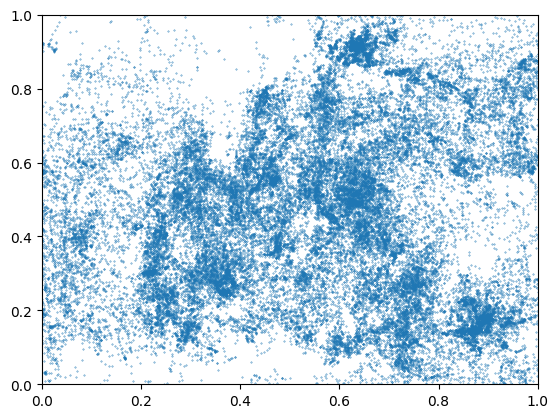

In [278]:
# Scatter plot the touch positions
plt.scatter(touch_positions_canvas[:, 0], touch_positions_canvas[:, 1], s=0.1)
# Set x and y to be from 0 to 1
plt.xlim([0, 1])
plt.ylim([0, 1])

100%|██████████| 18189/18189 [33:20<00:00,  9.09it/s] 


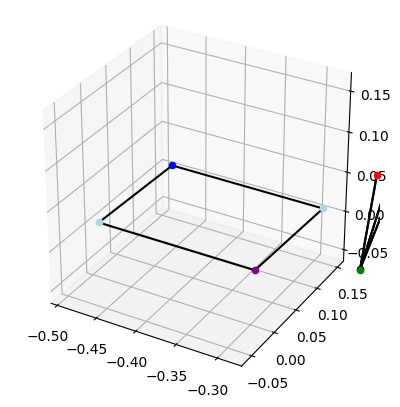

In [279]:
def plot_state(idx, ax=None):
    def draw_data(ax, points, lines):
        # points: each element is (x, y, z, color)
        # lines: each element is (x1, y1, z1, x2, y2, z2, color)
        for point in points:
            ax.scatter(point[0], point[1], point[2], c=point[3])
        for line in lines:
            ax.plot([line[0], line[3]], [line[1], line[4]], [line[2], line[5]], c=line[6])

    preserve_limits = False
    if ax is None:
        ax = plt.axes(projection='3d')
        ax.view_init(vertical_axis='y')
        fig = ax.figure
    else:
        preserve_limits = True
        fig = ax.figure
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        zlim = ax.get_zlim()
        ax.clear()
        ax.view_init(vertical_axis='y')
    
    points = []
    lines = []

    # Draw canvas corners
    # Middle corner is blue, side corners are light blue, and fourth corner is purple
    points.append([middle_corner[0], middle_corner[1], middle_corner[2], 'b'])
    points.append([side_corners[0][0], side_corners[0][1], side_corners[0][2], 'lightblue'])
    points.append([side_corners[1][0], side_corners[1][1], side_corners[1][2], 'lightblue'])
    points.append([fourth_corner[0], fourth_corner[1], fourth_corner[2], 'purple'])

    # Draw black lines connecting canvas corners
    lines.append([middle_corner[0], middle_corner[1], middle_corner[2], side_corners[0][0], side_corners[0][1], side_corners[0][2], 'k'])
    lines.append([middle_corner[0], middle_corner[1], middle_corner[2], side_corners[1][0], side_corners[1][1], side_corners[1][2], 'k'])
    lines.append([fourth_corner[0], fourth_corner[1], fourth_corner[2], side_corners[0][0], side_corners[0][1], side_corners[0][2], 'k'])
    lines.append([fourth_corner[0], fourth_corner[1], fourth_corner[2], side_corners[1][0], side_corners[1][1], side_corners[1][2], 'k'])

    # Draw pen points as red, orange, yellow
    points.append([states[idx,3,0], states[idx,3,1], states[idx,3,2], 'r'])
    points.append([states[idx,4,0], states[idx,4,1], states[idx,4,2], 'orange'])
    points.append([states[idx,5,0], states[idx,5,1], states[idx,5,2], 'y'])
    # Draw pen tip in green
    points.append([pen_tips[idx,0], pen_tips[idx,1], pen_tips[idx,2], 'g'])

    # Draw lines between pen points and the tip
    lines.append([states[idx,3,0], states[idx,3,1], states[idx,3,2], pen_tips[idx,0], pen_tips[idx,1], pen_tips[idx,2], 'k'])
    lines.append([states[idx,4,0], states[idx,4,1], states[idx,4,2], pen_tips[idx,0], pen_tips[idx,1], pen_tips[idx,2], 'k'])
    lines.append([states[idx,5,0], states[idx,5,1], states[idx,5,2], pen_tips[idx,0], pen_tips[idx,1], pen_tips[idx,2], 'k'])
    ax.plot([states[idx,3,0], pen_tips[idx,0]], [states[idx,3,1], pen_tips[idx,1]], [states[idx,3,2], pen_tips[idx,2]], c='k')
    ax.plot([states[idx,4,0], pen_tips[idx,0]], [states[idx,4,1], pen_tips[idx,1]], [states[idx,4,2], pen_tips[idx,2]], c='k')
    ax.plot([states[idx,5,0], pen_tips[idx,0]], [states[idx,5,1], pen_tips[idx,1]], [states[idx,5,2], pen_tips[idx,2]], c='k')
    # Draw lines between pen points
    lines.append([states[idx,3,0], states[idx,3,1], states[idx,3,2], states[idx,4,0], states[idx,4,1], states[idx,4,2], 'k'])
    lines.append([states[idx,3,0], states[idx,3,1], states[idx,3,2], states[idx,5,0], states[idx,5,1], states[idx,5,2], 'k'])
    lines.append([states[idx,4,0], states[idx,4,1], states[idx,4,2], states[idx,5,0], states[idx,5,1], states[idx,5,2], 'k'])

    # Draw touch position if it is not None
    if touch_positions_global[idx][0] is not None:
        points.append([touch_positions_global[idx,0], touch_positions_global[idx,1], touch_positions_global[idx,2], 'k'])
    
    draw_data(ax, points, lines)

    if preserve_limits:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_zlim(zlim)
    else:
        def set_axes_equal(ax: plt.Axes):
            """Set 3D plot axes to equal scale.

            Make axes of 3D plot have equal scale so that spheres appear as
            spheres and cubes as cubes.  Required since `ax.axis('equal')`
            and `ax.set_aspect('equal')` don't work on 3D.
            """
            limits = np.array([
                ax.get_xlim3d(),
                ax.get_ylim3d(),
                ax.get_zlim3d(),
            ])
            origin = np.mean(limits, axis=1)
            radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
            _set_axes_radius(ax, origin, radius)

        def _set_axes_radius(ax, origin, radius):
            x, y, z = origin
            ax.set_xlim3d([x - radius, x + radius])
            ax.set_ylim3d([y - radius, y + radius])
            ax.set_zlim3d([z - radius, z + radius])

        ax.set_box_aspect([1,1,1])
        set_axes_equal(ax)

    return fig, ax

# Make animation of states
fig, ax = plot_state(states.shape[0] // 2) # Set axes based on state during middle of painting
frames = []
framenum = 0
for i in tqdm(range(0, states.shape[0], 5)):
    fig, ax = plot_state(i, ax)
    fig.savefig(f"tmp/{framenum}.png")
    framenum += 1

In [5]:
import moviepy.editor
image_files = [os.path.join('tmp', f"{i}.png") for i in range(len(os.listdir('tmp')))]
clip = moviepy.editor.ImageSequenceClip(image_files, fps=24)
clip.write_videofile("mocap.mp4")

Moviepy - Building video mocap.mp4.
Moviepy - Writing video mocap.mp4



Moviepy - Done !
Moviepy - video ready mocap.mp4
